# **Project name: Endoscopic Capsule -- 131_m1_ResNet_LMR_zip**






# **Project configuration**



## General configuration


In [203]:
## Project folder
collab_path = '/content/'
project_path = collab_path
training_folder = 'TRAIN'
val_folder = 'VAL'

## Imagery folders
imagery_path = ''
raw_imagery_path = '/raw/'

## Drive folder
drive_path = '/content/drive'
drive_model_path = '/model/'
drive_log_path = '/log/'
drive_csv_path = '/csv_log/'

## Project dataset
file_id ="1JvSvYQJ4ieOJFAVMX04ybzQr45ra-ws2"
file_name = "LMR_Capstone_full.zip"
classes_file = "classes_paper.csv"
#image_size = 336
image_size = 100
image_bands = 3

## Training mode
single_dataset = True
num_samples_train = 0
num_samples_val = 0
validation_fraction = 0
retrain = False
validation_file = ''
weighted_train = False

## Training mode and configuration

In [204]:
############################

## Training
batch_size  = 128
num_epochs  = 10
learning_rate = 0.001
min_learning_rate = learning_rate / 100
patience = num_epochs
momentum = 0
retrain = False
model_name = "model_cnn_lumaro.h5"
drive_project_path = '/MyDrive/ML'
############################

mode01=True
mode02=False

mode11=False
mode12=False
mode13=False

mode21=False
mode22=False
mode23=False

#Mode 01
if (mode01):
  drive_project_path = '/MyDrive/ML_131_ResNet_mode01'
  single_dataset = True
  weighted_train = False
  training_file = 'split_all.csv'
  validation_fraction = .3

#Mode 02
if (mode02):
  drive_project_path = '/MyDrive/ML_131_ResNet_mode02'
  single_dataset = True
  weighted_train = True
  training_file = 'split_all.csv'
  validation_fraction = .3

#Mode 11
if (mode11):
  training_file = 'split_0.csv'
  validation_file = 'split_1.csv'
  single_dataset = False
  validation_fraction = 0
  num_samples_train = 0
  num_samples_val = 0
  weighted_train = False

#Mode 12
if (mode12):
  training_file = 'split_0.csv'
  validation_file = 'split_1.csv'
  single_dataset = False
  validation_fraction = 0
  num_samples_train = 0
  num_samples_val = 0
  weighted_train = True

#Mode 13
if (mode12):
  training_file = 'split_0.csv'
  validation_file = 'split_1.csv'
  single_dataset = False
  validation_fraction = 0
  num_samples_train = 1200
  num_samples_val = 1200
  weighted_train = False

#Mode 21
if (mode21):
  training_file = 'split_1.csv'
  validation_file = 'split_0.csv'
  single_dataset = False
  validation_fraction = 0
  num_samples_train = 0
  num_samples_val = 0
  weighted_train = False

#Mode 22
if (mode22):
  training_file = 'split_1.csv'
  validation_file = 'split_0.csv'
  single_dataset = False
  validation_fraction = 0
  num_samples_train = 0
  num_samples_val = 0
  weighted_train = True

#Mode 23
if (mode23):
  training_file = 'split_1.csv'
  validation_file = 'split_0.csv'
  single_dataset = False
  validation_fraction = 0
  num_samples_train = 1200
  num_samples_val = 1200
  weighted_train = False


## Loading Modules and Libraries

In [205]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

!pip install tensorflow-addons

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [206]:
import os                                               # OS module in Python provides a way of using operating system dependent functionality

import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import tensorflow_addons as tfa
import cv2                                              # Library for image processing

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet152,ResNet50
from tensorflow.keras.applications.densenet import DenseNet169

import sklearn.metrics as mtc
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from psutil import virtual_memory
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
import shutil

## Showing Environtment configuration

In [207]:
print("Tensorflow version: ",tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))
if ram_gb < 20:
  print('(Not using a high-RAM runtime)')
else:
  print('(You are using a high-RAM runtime!)')

Tensorflow version:  2.8.0
Num GPUs Available:  1
Your runtime has 27.3 gigabytes of available RAM
(You are using a high-RAM runtime!)


## Setting-up (Google-Drive)

In [208]:
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
if not os.path.exists(drive_path+drive_project_path):
  os.makedirs(drive_path+drive_project_path)
if not os.path.exists(drive_path+drive_project_path+drive_model_path):
  os.makedirs(drive_path+drive_project_path+drive_model_path)
if not os.path.exists(drive_path+drive_project_path+drive_log_path):
  os.makedirs(drive_path+drive_project_path+drive_log_path)
if not os.path.exists(drive_path+drive_project_path+drive_csv_path):
  os.makedirs(drive_path+drive_project_path+drive_csv_path)

## Setting-up the environtment (Collab)

In [210]:
if not os.path.exists(project_path):
  os.makedirs(project_path)

In [211]:
if not os.path.exists(file_name):
  !pip install gdown
  !gdown --id $file_id


In [212]:
#unzip the data
dir = project_path+imagery_path
!unzip -q -n $file_name -d $dir
dir


'/content/'

# **Loading and preparing classes**


In [213]:
'''
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(df_train.label),
#                                                 df_train.label)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(df_train.label), y=df_train.label)
class_weights = dict(enumerate(class_weights))
class_weights
'''

"\nfrom sklearn.utils import class_weight\n#class_weights = class_weight.compute_class_weight('balanced',\n#                                                 np.unique(df_train.label),\n#                                                 df_train.label)\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  classes=np.unique(df_train.label), y=df_train.label)\nclass_weights = dict(enumerate(class_weights))\nclass_weights\n"

In [214]:
file = project_path+classes_file
file

'/content/classes_paper.csv'

In [215]:
classes_weights = pd.read_csv(file)   # loading the labels
num_classes = len(classes_weights)
print("Num of classes: ",num_classes)
classes_weights

Num of classes:  11


,class,weight
0,Angiectasia,0.0285
1,Blood_fresh,1.0000
2,Erosion,0.1068
3,Erythematous,0.1667
4,Foreign_body,0.0373
5,Ileocecal_valve,0.0196
6,Lymphangiectasia,0.0982
7,Normal,0.0014
8,Pylorus,0.0235
9,Reduced_mucosal_view,0.0236


In [216]:
dic_weights = []
vec_weights = []
for i in range(len(classes_weights)):
  vec_weights.append(classes_weights['weight'][i])
vec_weights


[0.0285,
 1.0,
 0.1068,
 0.1667,
 0.0373,
 0.0196,
 0.0982,
 0.0014,
 0.0235,
 0.0236,
 0.0809]

In [217]:
dic_weights = dict(enumerate(vec_weights))
dic_weights

{0: 0.0285,
 1: 1.0,
 2: 0.1068,
 3: 0.1667,
 4: 0.0373,
 5: 0.0196,
 6: 0.0982,
 7: 0.0014,
 8: 0.0235,
 9: 0.0236,
 10: 0.0809}

In [218]:
vec_labels = []
for i in range(len(classes_weights)):
  vec_labels.append(classes_weights['class'][i])
vec_labels

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_body',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

# **Loading and preparing training data**


## Recovering info from training file

In [219]:
'''
# Reduction of Majority samples
df_train = pd.read_csv(path + "Training_set.csv")
df_minority = df_train[df_train.label != "Normal clean mucosa"]
# take random 3000 samples of majority class
df_majority_sample = df_train[df_train.label == "Normal clean mucosa"].sample(3000)
df_train = pd.concat([df_minority, df_majority_sample])
'''

'\n# Reduction of Majority samples\ndf_train = pd.read_csv(path + "Training_set.csv")\ndf_minority = df_train[df_train.label != "Normal clean mucosa"]\n# take random 3000 samples of majority class\ndf_majority_sample = df_train[df_train.label == "Normal clean mucosa"].sample(3000)\ndf_train = pd.concat([df_minority, df_majority_sample])\n'

In [220]:
file = project_path+imagery_path+training_file
file

'/content/split_all.csv'

In [221]:
labels = pd.read_csv(file)   # loading the labels
labels

,filename,label
0,ad91cf7ca91440aa_873.jpg,Angiectasia
1,ad91cf7ca91440aa_872.jpg,Angiectasia
2,ad91cf7ca91440aa_5961.jpg,Angiectasia
3,ad91cf7ca91440aa_5960.jpg,Angiectasia
4,ad91cf7ca91440aa_5959.jpg,Angiectasia
...,...,...
47156,d626f4f4a5ac4785_32757.jpg,Ulcer
47157,d626f4f4a5ac4785_32756.jpg,Ulcer
47158,d626f4f4a5ac4785_32755.jpg,Ulcer
47159,d626f4f4a5ac4785_25806.jpg,Ulcer


In [222]:
dir = project_path+imagery_path+'raw/'
dir

'/content/raw/'

In [223]:
file_paths = [dir + fname for fname in labels['filename']]
file_paths

['/content/raw/ad91cf7ca91440aa_873.jpg',
 '/content/raw/ad91cf7ca91440aa_872.jpg',
 '/content/raw/ad91cf7ca91440aa_5961.jpg',
 '/content/raw/ad91cf7ca91440aa_5960.jpg',
 '/content/raw/ad91cf7ca91440aa_5959.jpg',
 '/content/raw/ad91cf7ca91440aa_5958.jpg',
 '/content/raw/ad91cf7ca91440aa_5957.jpg',
 '/content/raw/ad91cf7ca91440aa_5956.jpg',
 '/content/raw/ad91cf7ca91440aa_5955.jpg',
 '/content/raw/ad91cf7ca91440aa_4754.jpg',
 '/content/raw/ad91cf7ca91440aa_4753.jpg',
 '/content/raw/64440803f87b4843_22580.jpg',
 '/content/raw/64440803f87b4843_22579.jpg',
 '/content/raw/64440803f87b4843_22578.jpg',
 '/content/raw/64440803f87b4843_21417.jpg',
 '/content/raw/64440803f87b4843_21416.jpg',
 '/content/raw/64440803f87b4843_21415.jpg',
 '/content/raw/64440803f87b4843_21395.jpg',
 '/content/raw/64440803f87b4843_21394.jpg',
 '/content/raw/64440803f87b4843_21393.jpg',
 '/content/raw/64440803f87b4843_21382.jpg',
 '/content/raw/64440803f87b4843_21381.jpg',
 '/content/raw/64440803f87b4843_21380.jpg',
 

In [224]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  47161 matches the number of filenames i.e.  47161


#### Adding the file_paths to dataframe

In [225]:
train_data = labels
train_data['filepaths'] = file_paths
print("Num of train_data: ",len(train_data))
train_data      

Num of train_data:  47161


,filename,label,filepaths
0,ad91cf7ca91440aa_873.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_873.jpg
1,ad91cf7ca91440aa_872.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_872.jpg
2,ad91cf7ca91440aa_5961.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_5961.jpg
3,ad91cf7ca91440aa_5960.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_5960.jpg
4,ad91cf7ca91440aa_5959.jpg,Angiectasia,/content/raw/ad91cf7ca91440aa_5959.jpg
...,...,...,...
47156,d626f4f4a5ac4785_32757.jpg,Ulcer,/content/raw/d626f4f4a5ac4785_32757.jpg
47157,d626f4f4a5ac4785_32756.jpg,Ulcer,/content/raw/d626f4f4a5ac4785_32756.jpg
47158,d626f4f4a5ac4785_32755.jpg,Ulcer,/content/raw/d626f4f4a5ac4785_32755.jpg
47159,d626f4f4a5ac4785_25806.jpg,Ulcer,/content/raw/d626f4f4a5ac4785_25806.jpg


## Plotting some training images


In [226]:
def show_image(image,label):
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
  orig_img = cv2.imread(image)
  orig_img = orig_img[..., ::-1]
  processed_img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  ax1.imshow(orig_img)
  ax2.imshow(processed_img, cmap='gray', vmin=0, vmax=255)
  ax1.set_title(f'RGB Image class {label}')
  ax2.set_title(f'Gray Image class {label}')

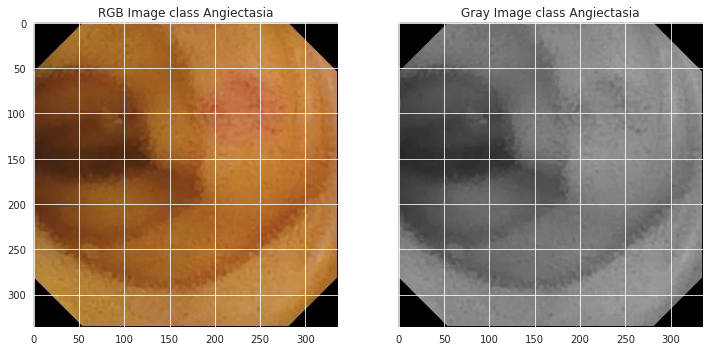

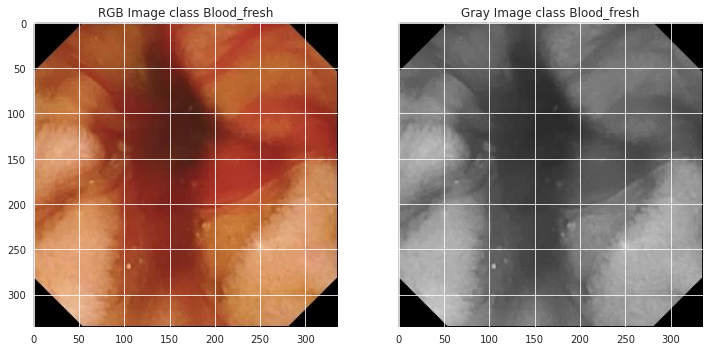

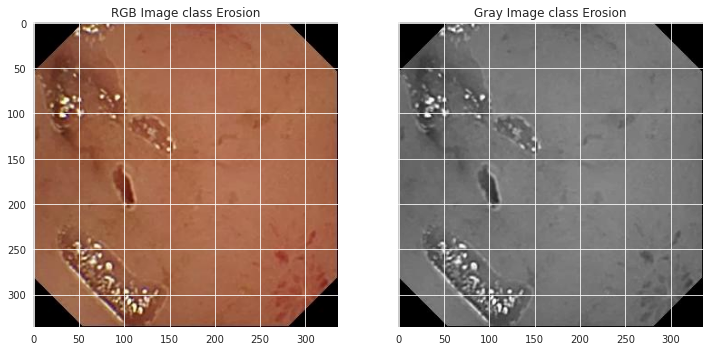

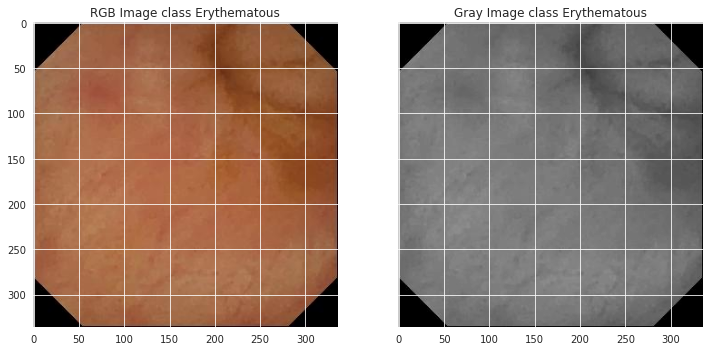

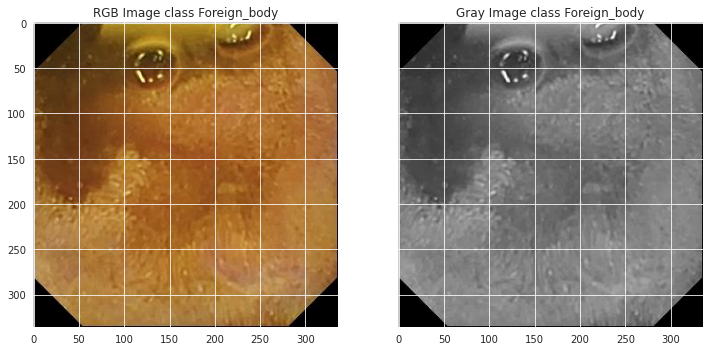

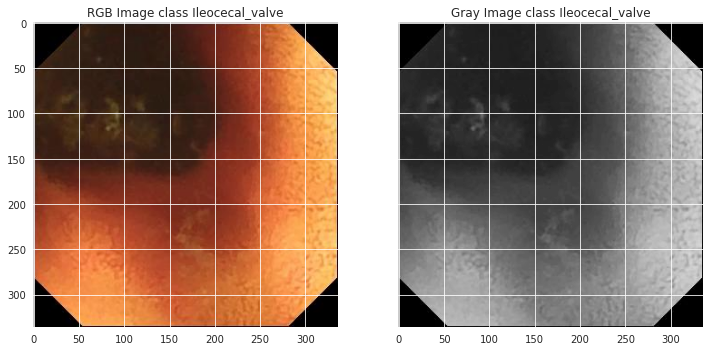

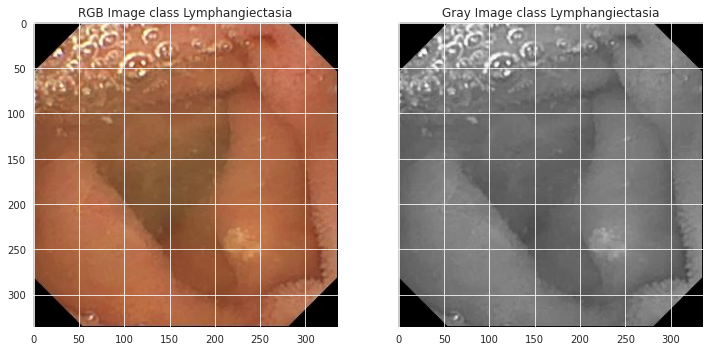

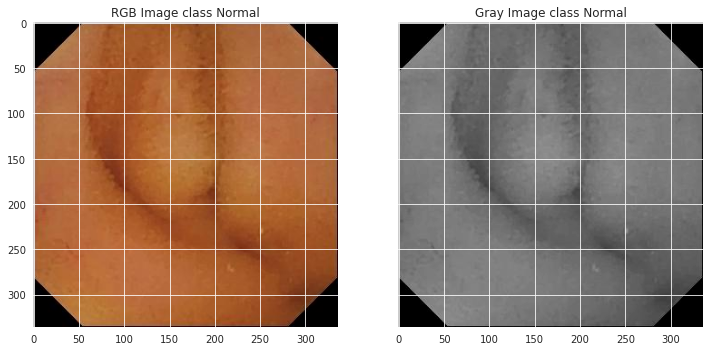

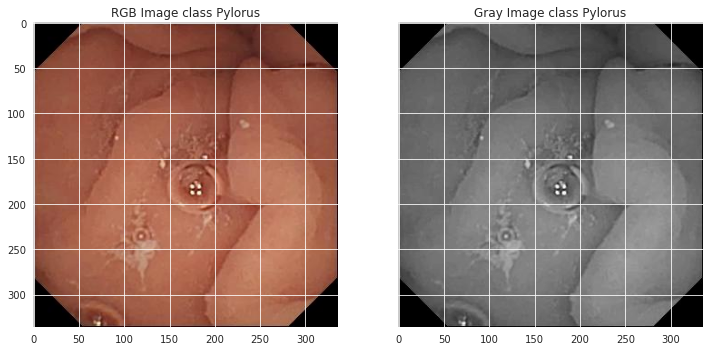

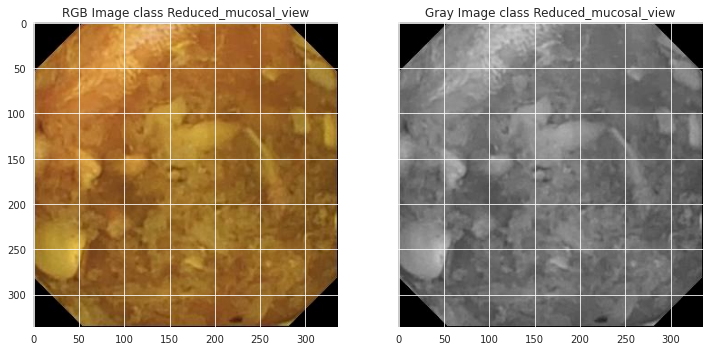

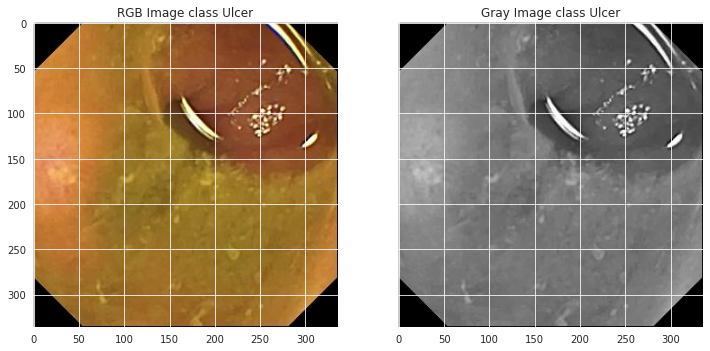

In [227]:
for item in vec_labels:
  sub_list = train_data[train_data['label'] == item].sample().reset_index()
  show_image(sub_list['filepaths'][0],sub_list['label'][0])


## Make Folders for training images

In [228]:
_dir_train = os.path.join(project_path,training_folder)
_dir_train

'/content/TRAIN'

In [229]:
if os.path.exists(_dir_train):
  shutil.rmtree(_dir_train)
os.path.exists(_dir_train)

False

In [230]:
if not os.path.exists(_dir_train):
    os.makedirs(_dir_train)
_dir_train

'/content/TRAIN'

In [231]:
labels = train_data['label'].unique().tolist()
labels

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_body',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

In [232]:
for label in labels:
  _dir = os.path.join(project_path,training_folder,label)
  if not os.path.exists(_dir):
    os.makedirs(_dir)

## Copy Training images to respective folders

In [233]:
if (num_samples_train == 0):
  for i in tqdm(train_data.index):
    images = train_data["filepaths"][i]
    lbls = train_data["label"][i]
    dest = os.path.join(project_path,training_folder,lbls)
    if os.stat(images).st_size != 0:
      shutil.copy(images,dest)

100%|██████████| 47161/47161 [00:05<00:00, 8557.11it/s]


In [234]:
labels = train_data['label'].unique().tolist()
labels

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_body',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

In [235]:
counts = train_data.label.value_counts()
counts

Normal                  34338
Ileocecal_valve          4189
Reduced_mucosal_view     2906
Pylorus                  1529
Angiectasia               866
Ulcer                     854
Foreign_body              776
Lymphangiectasia          592
Erosion                   506
Blood_fresh               446
Erythematous              159
Name: label, dtype: int64

In [236]:
if (num_samples_train > 0):
  for label in tqdm(labels):
    clas_data = train_data[train_data['label']==label]
    clas_data = clas_data.sample(frac=1)
    lap = 1000
    num = num_samples_train
    while (num > 0):
      for i in clas_data.index:
        image = clas_data["filepaths"][i]
        lbl = clas_data["label"][i]
        name = str(lap)+'_'+os.path.basename(image)
        dest = os.path.join(project_path,training_folder,lbl,name)
        if os.stat(image).st_size != 0:
          if (num > 0):
            shutil.copy(image,dest)
            num = num - 1
      lap = lap + 1


## Statistics of training data



In [237]:
train_data['label'].unique().tolist()

['Angiectasia',
 'Blood_fresh',
 'Erosion',
 'Erythematous',
 'Foreign_body',
 'Ileocecal_valve',
 'Lymphangiectasia',
 'Normal',
 'Pylorus',
 'Reduced_mucosal_view',
 'Ulcer']

In [238]:
train_data.label.value_counts()

Normal                  34338
Ileocecal_valve          4189
Reduced_mucosal_view     2906
Pylorus                  1529
Angiectasia               866
Ulcer                     854
Foreign_body              776
Lymphangiectasia          592
Erosion                   506
Blood_fresh               446
Erythematous              159
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


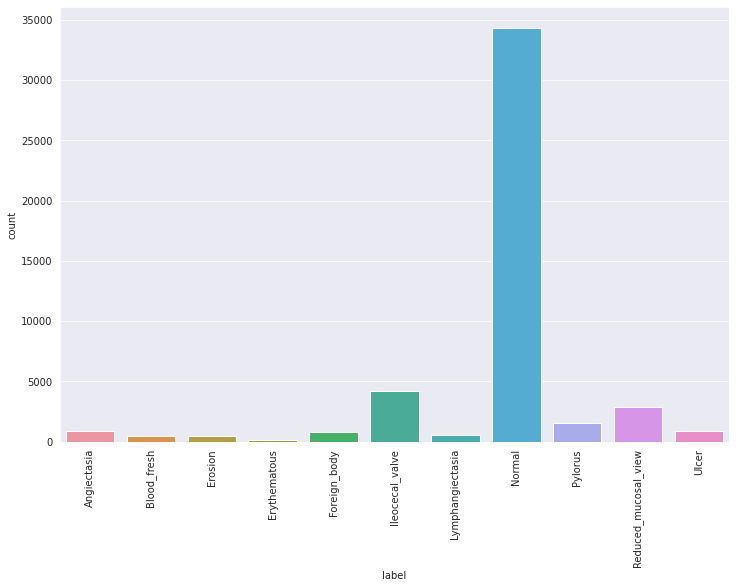

In [239]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(train_data.label)

In [240]:
def f(r):
  if r == "Angiectasia":
    return 0
  elif r == "Blood_fresh":
    return 1
  elif r == "Erosion":
    return 2
  elif r == "Erythematous":
    return 3
  elif r == "Foreign_body":
    return 4
  elif r == "Ileocecal_valve":
    return 5
  elif r == "Lymphangiectasia":
    return 6
  elif r == "Normal":
    return 7
  elif r == "Pylorus":
    return 8
  elif r == "Reduced_mucosal_view":
    return 9
  else:
    return 10

In [241]:
train_data['label'] = train_data['label'].apply(f)

In [242]:
labels = train_data['label'].unique().tolist()
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


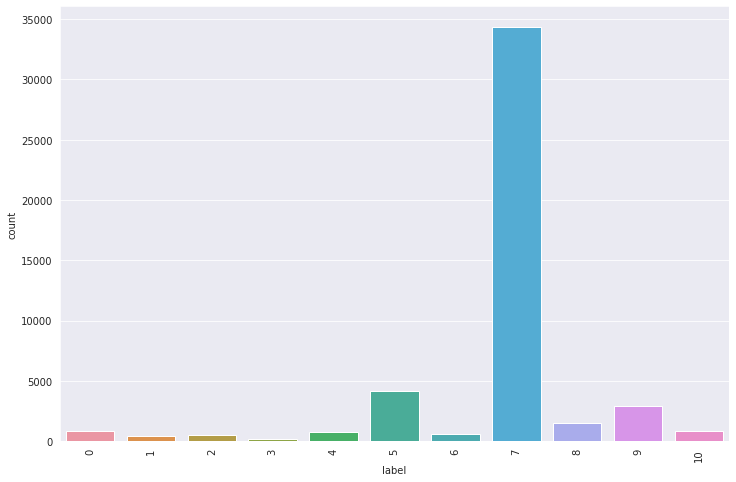

In [243]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation =90)
sns.countplot(train_data.label)

## Training Dataset creation


In [244]:
if (not single_dataset):
  subset = None
  validation_split = 0
else:
  subset = 'training'
  validation_split = validation_fraction

train_dataset = tf.keras.utils.image_dataset_from_directory(
    project_path + training_folder,
    labels = "inferred",
    label_mode = "categorical",
    class_names = None,
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = (image_size, image_size),
    shuffle = True,
    seed = 42,
    validation_split = validation_split,
    subset = subset,
    interpolation = "bilinear",
    follow_links = False,
    crop_to_aspect_ratio = False
)

train_dataset_len = len(train_dataset.file_paths)

Found 47161 files belonging to 11 classes.
Using 33013 files for training.


# **Loading and preparing validation data** (as a fraction of main dataset)

## Validation Dataset creation


In [245]:
if (single_dataset):
  val_dataset = tf.keras.utils.image_dataset_from_directory(
      project_path + training_folder,
      labels = "inferred",
      label_mode = "categorical",
      class_names = None,
      color_mode = "rgb",
      batch_size = batch_size,
      image_size = (image_size, image_size),
      shuffle = True,
      seed = 42,
      validation_split = validation_fraction,
      subset = "validation",
      interpolation = "bilinear",
      follow_links = False,
      crop_to_aspect_ratio = False
  )
  val_dataset_len = len(val_dataset.file_paths)

Found 47161 files belonging to 11 classes.
Using 14148 files for validation.


# **Loading and preparing validation data** (from an independent images list)

## Recovering info from validation file

In [246]:
if (not single_dataset):
  file = project_path+imagery_path+validation_file
file

'/content/split_all.csv'

In [247]:
if (not single_dataset):
  labels = pd.read_csv(file)   # loading the labels
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [248]:
if (not single_dataset):
  dir = project_path+imagery_path+'raw/'
dir

'/content/raw/'

In [249]:
if (not single_dataset):
  file_paths = [dir + fname for fname in labels['filename']]
file_paths

['/content/raw/ad91cf7ca91440aa_873.jpg',
 '/content/raw/ad91cf7ca91440aa_872.jpg',
 '/content/raw/ad91cf7ca91440aa_5961.jpg',
 '/content/raw/ad91cf7ca91440aa_5960.jpg',
 '/content/raw/ad91cf7ca91440aa_5959.jpg',
 '/content/raw/ad91cf7ca91440aa_5958.jpg',
 '/content/raw/ad91cf7ca91440aa_5957.jpg',
 '/content/raw/ad91cf7ca91440aa_5956.jpg',
 '/content/raw/ad91cf7ca91440aa_5955.jpg',
 '/content/raw/ad91cf7ca91440aa_4754.jpg',
 '/content/raw/ad91cf7ca91440aa_4753.jpg',
 '/content/raw/64440803f87b4843_22580.jpg',
 '/content/raw/64440803f87b4843_22579.jpg',
 '/content/raw/64440803f87b4843_22578.jpg',
 '/content/raw/64440803f87b4843_21417.jpg',
 '/content/raw/64440803f87b4843_21416.jpg',
 '/content/raw/64440803f87b4843_21415.jpg',
 '/content/raw/64440803f87b4843_21395.jpg',
 '/content/raw/64440803f87b4843_21394.jpg',
 '/content/raw/64440803f87b4843_21393.jpg',
 '/content/raw/64440803f87b4843_21382.jpg',
 '/content/raw/64440803f87b4843_21381.jpg',
 '/content/raw/64440803f87b4843_21380.jpg',
 

In [250]:
# Confirm if number of images is same as number of labels given
if (not single_dataset):
  if len(labels) == len(file_paths):
      print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
  else:
      print('Number of labels does not match the number of filenames')

#### Adding the file_paths to dataframe

In [251]:
val_data = None
if (not single_dataset):
  val_data = labels
  val_data['filepaths'] = file_paths
  print("Num of val_data: ", len(val_data))
val_data      

In [252]:
_dir_val = None
if (not single_dataset):
  _dir_val = os.path.join(project_path,val_folder)
  if os.path.exists(_dir_val):
    shutil.rmtree(_dir_val)
  print(os.path.exists(_dir_val))

In [253]:
if (not single_dataset):
  if not os.path.exists(_dir_val):
      os.makedirs(_dir_val)

In [254]:
if (not single_dataset):
  labels = val_data['label'].unique().tolist()
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [255]:
if (not single_dataset):
  for label in labels:
    _dir = os.path.join(project_path,val_folder,label)
    if not os.path.exists(_dir):
      os.makedirs(_dir)

## Plotting some validation images


In [256]:
if (not single_dataset):
  for item in vec_labels:
    sub_list = val_data[val_data['label'] == item].sample().reset_index()
    show_image(sub_list['filepaths'][0],sub_list['label'][0])

## Copy Validation images to respective folders

In [257]:
if (not single_dataset):
  if (num_samples_val == 0):
    for i in tqdm(val_data.index):
      images = val_data["filepaths"][i]
      lbls = val_data["label"][i]
      dest = os.path.join(project_path,val_folder,lbls)
      if os.stat(images).st_size != 0:
        shutil.copy(images,dest)

In [258]:
if (not single_dataset):
  labels = val_data['label'].unique().tolist()
  counts = val_data.label.value_counts()
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [259]:
counts

Normal                  34338
Ileocecal_valve          4189
Reduced_mucosal_view     2906
Pylorus                  1529
Angiectasia               866
Ulcer                     854
Foreign_body              776
Lymphangiectasia          592
Erosion                   506
Blood_fresh               446
Erythematous              159
Name: label, dtype: int64

In [260]:
if (not single_dataset):
  if (num_samples_val > 0):
    for label in tqdm(labels):
      clas_data = val_data[val_data['label']==label]
      clas_data = clas_data.sample(frac=1)
      lap = 1000
      num = num_samples_val
      while (num > 0):
        for i in clas_data.index:
          image = clas_data["filepaths"][i]
          lbl = clas_data["label"][i]
          name = str(lap)+'_'+os.path.basename(image)
          dest = os.path.join(project_path,val_folder,lbl,name)
          if os.stat(image).st_size != 0:
            if (num > 0):
              shutil.copy(image,dest)
              num = num - 1
        lap = lap + 1


## Statistics of validation data

In [261]:
if (not single_dataset):
  print(val_data['label'].unique().tolist())

In [262]:
if (not single_dataset):
  print(val_data.label.value_counts())

In [263]:
if (not single_dataset):
  sns.set_style('darkgrid')
  plt.figure(figsize=(12,8))
  plt.xticks(rotation =90)
  sns.countplot(val_data.label)

In [264]:
if (not single_dataset):
  val_data['label'] = val_data['label'].apply(f)
  labels = val_data['label'].unique().tolist()
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [265]:
if (not single_dataset):
  sns.set_style('darkgrid')
  plt.figure(figsize=(12,8))
  plt.xticks(rotation =90)
  sns.countplot(val_data.label)

## Validation Dataset creation


In [266]:
if (not single_dataset):
  val_dataset = tf.keras.utils.image_dataset_from_directory(
      project_path + val_folder,
      labels = "inferred",
      label_mode = "categorical",
      class_names = None,
      color_mode = "rgb",
      batch_size = batch_size,
      image_size = (image_size, image_size),
      shuffle = True,
      seed = 42,
      validation_split = None,
      subset = None,
      interpolation = "bilinear",
      follow_links = False,
      crop_to_aspect_ratio = False
  )
  val_dataset_len = len(val_dataset.file_paths)

# **Training**

## Prefetched and cached datasets

In [267]:
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Definition of the model

In [268]:
pre_trained_model = ResNet152(include_top=False, weights= 'imagenet', pooling='avg')
for layer in pre_trained_model.layers:  
    layer.trainable=False

inputs = tf.keras.layers.Input((image_size, image_size, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs) # Preprocessing layer, normalization -1 1
x = pre_trained_model(x)
x = tf.keras.layers.Dropout(0.4)(x)      
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)   
out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)           

model = tf.keras.Model(inputs=inputs, outputs=out) 

#### Model Summary

In [269]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               2622

#### Model Plot

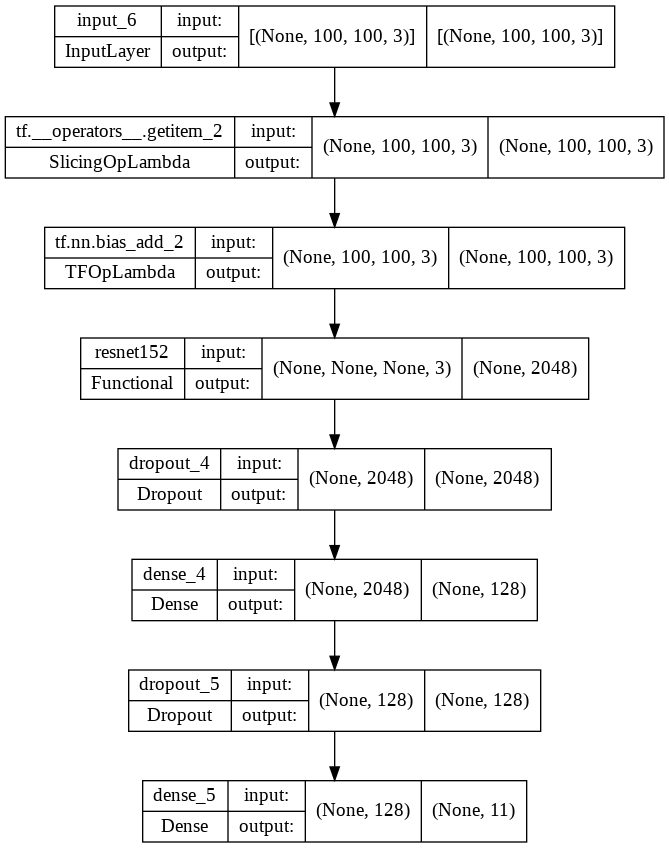

In [270]:
tf.keras.utils.plot_model(model, show_shapes=True)


### Model Compilation

In [271]:
if (weighted_train):
  loss_weights=vec_weights
else:
  loss_weights=None

model.compile(optimizer = tf.optimizers.SGD(learning_rate=learning_rate,momentum=momentum),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              loss_weights = loss_weights,
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.CategoricalCrossentropy(),
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives(), 
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.TruePositives(), 
                       tfa.metrics.F1Score(num_classes=num_classes, average="micro"), 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes)])


## Setting up callbacks

In [272]:
'''
MoreCallbacks
EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
'''

"\nMoreCallbacks\nEarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),\nReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)\n"

In [273]:
model_filepath = drive_path + drive_project_path + drive_model_path +  model_name
model_filepath

'/content/drive/MyDrive/ML_131_ResNet_mode01/model/model_cnn_lumaro.h5'

In [274]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_filepath,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [275]:
csv_log = drive_path+drive_project_path+drive_csv_path+"csv_log.csv"
csv_log

'/content/drive/MyDrive/ML_131_ResNet_mode01/csv_log/csv_log.csv'

In [276]:
if retrain:
  model.load_weights(model_filepath)
  csvlog_callback = tf.keras.callbacks.CSVLogger(csv_log, separator=',', append=True)
  train_history = pd.read_csv(csv_log)
  initial_epoch = 1+(train_history['epoch'].tail(1).tolist())[0]
else:
  initial_epoch = 0
  csvlog_callback = tf.keras.callbacks.CSVLogger(csv_log, separator=',', append=False)

In [277]:
log_filepath = drive_path + drive_project_path + drive_log_path 
log_filepath

'/content/drive/MyDrive/ML_131_ResNet_mode01/log/'

In [278]:
log_callback = tf.keras.callbacks.TensorBoard(log_filepath, histogram_freq=1)

In [279]:
terminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [280]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', 
                                                  factor=0.5,
                                                  patience=patience, 
                                                  min_lr=min_learning_rate)

## Fiting the model

In [281]:
%tensorboard --logdir $log_filepath

Reusing TensorBoard on port 6006 (pid 450), started 1:38:40 ago. (Use '!kill 450' to kill it.)

<IPython.core.display.Javascript object>

In [282]:

dic_weights

{0: 0.0285,
 1: 1.0,
 2: 0.1068,
 3: 0.1667,
 4: 0.0373,
 5: 0.0196,
 6: 0.0982,
 7: 0.0014,
 8: 0.0235,
 9: 0.0236,
 10: 0.0809}

In [283]:
gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a2a0f949-1e3e-0d42-dd50-916774316ee2)


In [284]:
if (weighted_train):
  class_weight=dic_weights
else:
  class_weight=None
if (num_epochs > 0):
 
  train_history = model.fit(train_dataset,
                          initial_epoch=initial_epoch,
                          epochs=initial_epoch+num_epochs,
                          batch_size=batch_size,
                          validation_data=val_dataset,
                          class_weight=class_weight,
                          callbacks=[reduce_lr, cp_callback, log_callback, csvlog_callback, terminateOnNaN])

Epoch 1/10
258/258 [==============================] - ETA: 0s - loss: 1.4549 - categorical_accuracy: 0.6576 - categorical_crossentropy: 1.4549 - false_negatives_8: 13049.0000 - false_positives_8: 7921.0000 - true_negatives_8: 322209.0000 - true_positives_8: 19964.0000 - f1_score: 0.6576 - precision_13: 0.7159 - recall_13: 0.6047 - MatthewsCorrelationCoefficient: 0.1502
Epoch 1: val_loss improved from inf to 0.85385, saving model to /content/drive/MyDrive/ML_131_ResNet_mode01/model/model_cnn_lumaro.h5
258/258 [==============================] - 81s 262ms/step - loss: 1.4549 - categorical_accuracy: 0.6576 - categorical_crossentropy: 1.4549 - false_negatives_8: 13049.0000 - false_positives_8: 7921.0000 - true_negatives_8: 322209.0000 - true_positives_8: 19964.0000 - f1_score: 0.6576 - precision_13: 0.7159 - recall_13: 0.6047 - MatthewsCorrelationCoefficient: 0.1502 - val_loss: 0.8539 - val_categorical_accuracy: 0.7575 - val_categorical_crossentropy: 0.8539 - val_false_negatives_8: 4029.000

'\n  train_history = model.fit(train_dataset,\n                              epochs=num_epochs,\n                              validation_data=val_dataset)\n\n\n'

In [285]:
if (num_epochs > 0):
  for key in train_history.history.keys():
    print(key)

loss
categorical_accuracy
categorical_crossentropy
false_negatives_8
false_positives_8
true_negatives_8
true_positives_8
f1_score
precision_13
recall_13
MatthewsCorrelationCoefficient
val_loss
val_categorical_accuracy
val_categorical_crossentropy
val_false_negatives_8
val_false_positives_8
val_true_negatives_8
val_true_positives_8
val_f1_score
val_precision_13
val_recall_13
val_MatthewsCorrelationCoefficient
lr


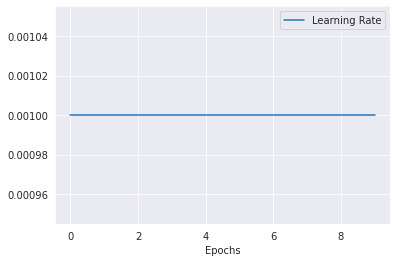

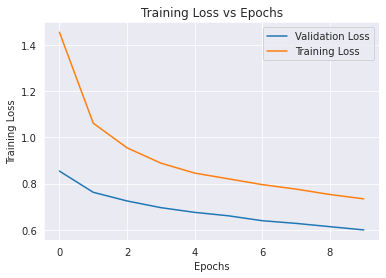

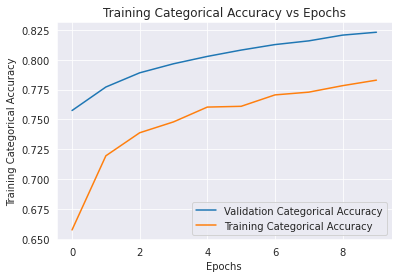

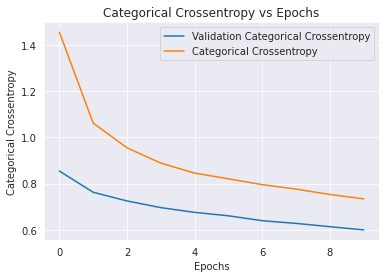

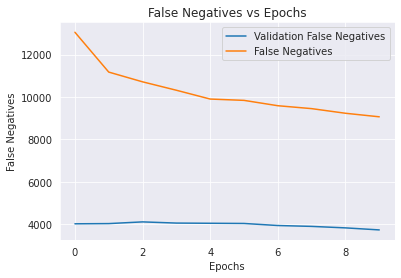

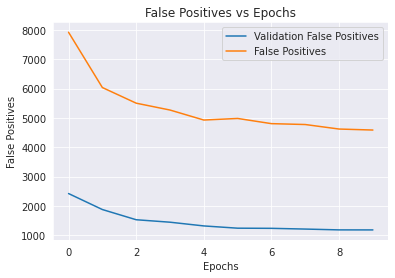

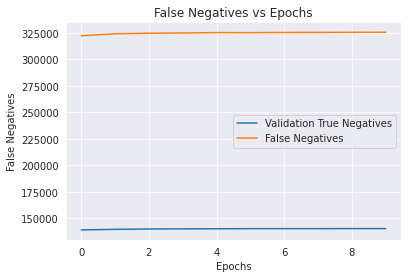

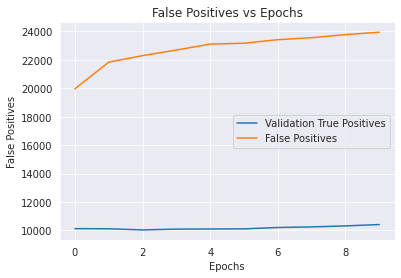

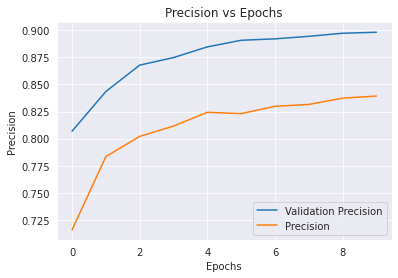

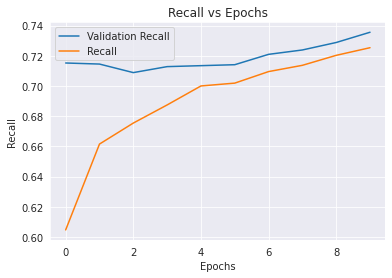

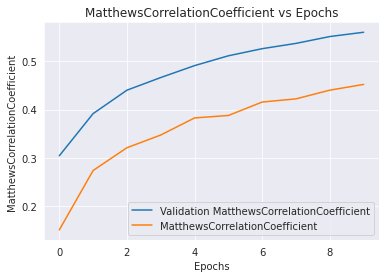

In [301]:
#PLOT HISTORY
def show_history(history, label_a, name_a=None, label_b=None, name_b=None):
  plt.plot(history[label_a],label=name_a)
  if (label_b != None):
    plt.plot(history[label_b],label=name_b)
  plt.xlabel('Epochs')
  if (name_b != None):
    plt.ylabel(name_b)
    plt.title(name_b+' vs Epochs')
  plt.legend()
  plt.show()

def make_plots(history):
  show_history(train_history.history, 'lr','Learning Rate')
  show_history(train_history.history, 'val_loss','Validation Loss',
                                      'loss','Training Loss')
  show_history(train_history.history, 'val_categorical_accuracy','Validation Categorical Accuracy',
                                      'categorical_accuracy','Training Categorical Accuracy')
  show_history(train_history.history, 'val_categorical_crossentropy','Validation Categorical Crossentropy',
                                      'categorical_crossentropy','Categorical Crossentropy')
  show_history(train_history.history, 'val_false_negatives_8','Validation False Negatives',
                                      'false_negatives_8','False Negatives')
  show_history(train_history.history, 'val_false_positives_8','Validation False Positives',
                                      'false_positives_8','False Positives')
  show_history(train_history.history, 'val_true_negatives_8','Validation True Negatives',
                                      'true_negatives_8','False Negatives')
  show_history(train_history.history, 'val_true_positives_8','Validation True Positives',
                                      'true_positives_8','False Positives') 
  show_history(train_history.history, 'val_precision_13','Validation Precision',
                                      'precision_13','Precision')
  show_history(train_history.history, 'val_recall_13','Validation Recall',
                                      'recall_13','Recall')
  show_history(train_history.history, 'val_MatthewsCorrelationCoefficient','Validation MatthewsCorrelationCoefficient',
                                      'MatthewsCorrelationCoefficient','MatthewsCorrelationCoefficient')

if (num_epochs > 0):
  make_plots(train_history.history)

In [302]:
csv_train_history = pd.read_csv(csv_log)
for key in csv_train_history.keys():
    print(key)

epoch
MatthewsCorrelationCoefficient
categorical_accuracy
categorical_crossentropy
f1_score
false_negatives_8
false_positives_8
loss
lr
precision_13
recall_13
true_negatives_8
true_positives_8
val_MatthewsCorrelationCoefficient
val_categorical_accuracy
val_categorical_crossentropy
val_f1_score
val_false_negatives_8
val_false_positives_8
val_loss
val_precision_13
val_recall_13
val_true_negatives_8
val_true_positives_8


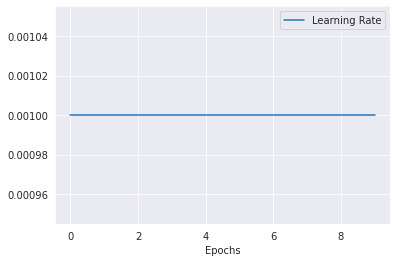

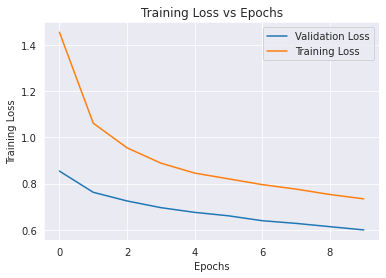

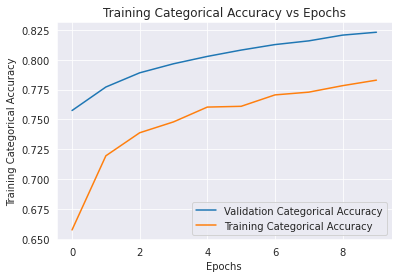

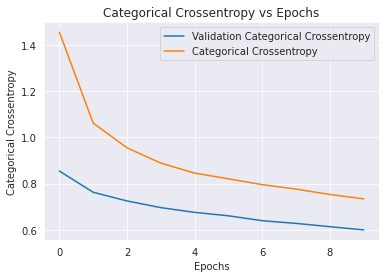

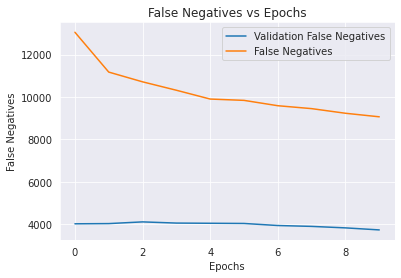

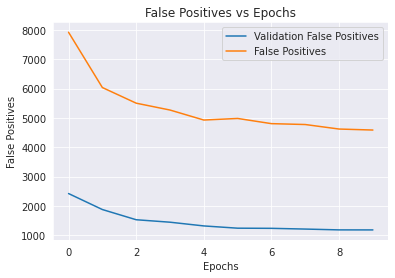

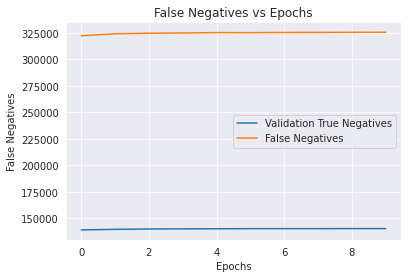

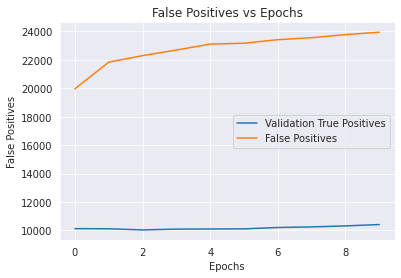

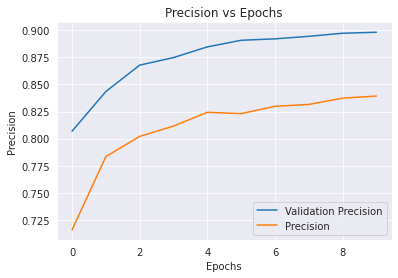

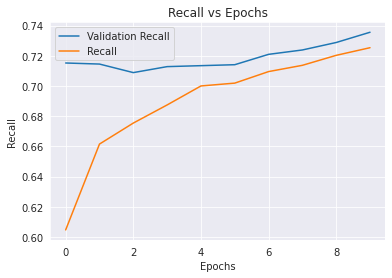

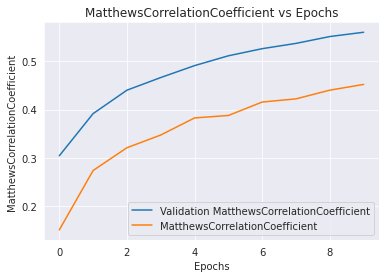

In [303]:
#PLOT HISTORY
make_plots(csv_train_history)


## Evaluating the model

In [309]:
eval = model.evaluate(val_dataset)

111/111 [==============================] - 15s 132ms/step - loss: 0.5992 - categorical_accuracy: 0.8229 - categorical_crossentropy: 0.5992 - false_negatives_8: 3741.0000 - false_positives_8: 1182.0000 - true_negatives_8: 140298.0000 - true_positives_8: 10407.0000 - f1_score: 0.8229 - precision_13: 0.8980 - recall_13: 0.7356 - MatthewsCorrelationCoefficient: 0.5607


In [314]:

print('loss = {:.3f}'.format(eval[0]))
print('categorical_accuracy = {:.3f}'.format(eval[1]))
print('categorical_crossentropy = {:.3f}'.format(eval[2]))
print('false_negatives = ',int(eval[3]))
print('false_positives = ',int(eval[4]))
print('true_negatives = ',int(eval[5]))
print('true_positives = ',int(eval[6]))
print('f1_score = {:.3f}'.format(eval[7]))
print('precision = {:.3f}'.format(eval[8]))
print('recall = {:.3f}'.format(eval[9]))
print('MatthewsCorrelationCoefficient = {:.3f}'.format(eval[10]))


loss = 0.599
categorical_accuracy = 0.823
categorical_crossentropy = 0.599
false_negatives =  3741
false_positives =  1182
true_negatives =  140298
true_positives =  10407
f1_score = 0.823
precision = 0.898
recall = 0.736
MatthewsCorrelationCoefficient = 0.561


# **Make Prediction and Analysis on Validation Dataset**


In [317]:
y_val = []
prediction = []
for images, labels in val_dataset:
    for label in labels:
      y_val.append(np.nanargmax(label.numpy()))
    preds = model.predict(images)
    for pred in preds:
      prediction.append(np.nanargmax(pred)) 

In [320]:
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([  271,   133,   150,    52,   217,  1263,   191, 10336,   431,
          847,   257]))

In [321]:
np.unique(prediction, return_counts=True)

(array([ 0,  1,  4,  5,  6,  7,  8,  9, 10]),
 array([  208,    41,    89,  1027,     7, 11608,   151,   969,    48]))

In [322]:
def test_model(y_true, y_predicted):
    print("Accuracy = {:.3f}".format(mtc.accuracy_score(y_true, y_predicted)))
    print("Accuracy Balanced = {:.3f}".format(mtc.balanced_accuracy_score(y_true, y_predicted)))
    
    print("Precision micro = {:.3f}".format(mtc.precision_score(y_true,y_predicted, average="micro")))
    print("Precision macro = {:.3f}".format(mtc.precision_score(y_true,y_predicted, average="macro")))
    print("Precision weighted = {:.3f}".format(mtc.precision_score(y_true,y_predicted, average="weighted")))
    
    print("Recall micro = {:.3f}".format(mtc.recall_score(y_true, y_predicted, average="micro")))
    print("Recall macro = {:.3f}".format(mtc.recall_score(y_true, y_predicted, average="macro")))
    print("Recall weighted = {:.3f}".format(mtc.recall_score(y_true, y_predicted, average="weighted")))

    print("F1 micro = {:.3f}".format(mtc.f1_score(y_true, y_predicted, average="micro")))
    print("F1 macro = {:.3f}".format(mtc.f1_score(y_true, y_predicted, average="macro")))
    print("F1 weighted = {:.3f}".format(mtc.f1_score(y_true, y_predicted, average="weighted")))

    print("MCC = {:.3f}".format(mtc.matthews_corrcoef(y_true, y_predicted)))
    print("Kappa = {:.3f}".format(mtc.cohen_kappa_score(y_true, y_predicted)))


In [323]:
test_model(y_val, prediction)

Accuracy = 0.823
Accuracy Balanced = 0.339
Precision micro = 0.823
Precision macro = 0.568
Precision weighted = 0.793
Recall micro = 0.823
Recall macro = 0.339
Recall weighted = 0.823
F1 micro = 0.823
F1 macro = 0.383
F1 weighted = 0.793
MCC = 0.561
Kappa = 0.545


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [324]:
#classification_report
report = classification_report(y_val, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.61      0.69       271
           1       0.98      0.30      0.46       133
           2       0.00      0.00      0.00       150
           3       0.00      0.00      0.00        52
           4       0.65      0.27      0.38       217
           5       0.64      0.52      0.57      1263
           6       0.57      0.02      0.04       191
           7       0.86      0.97      0.91     10336
           8       0.54      0.19      0.28       431
           9       0.66      0.75      0.70       847
          10       0.56      0.11      0.18       257

    accuracy                           0.82     14148
   macro avg       0.57      0.34      0.38     14148
weighted avg       0.79      0.82      0.79     14148



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [325]:
# confusion matrix
cm = pd.DataFrame(confusion_matrix(y_val, prediction))
cm

,0,1,2,3,4,5,6,7,8,9,10
0,166,0,0,0,0,2,0,86,15,1,1
1,4,40,0,0,0,20,0,67,1,0,1
2,0,0,0,0,0,4,0,130,13,1,2
3,1,0,0,0,0,0,0,51,0,0,0
4,1,0,0,0,58,7,0,147,0,4,0
5,3,0,0,0,7,653,1,423,0,172,4
6,15,0,0,0,13,14,4,142,1,0,2
7,16,0,0,0,11,156,2,9976,25,145,5
8,1,0,0,0,0,14,0,326,81,3,6
9,0,0,0,0,0,70,0,139,0,638,0


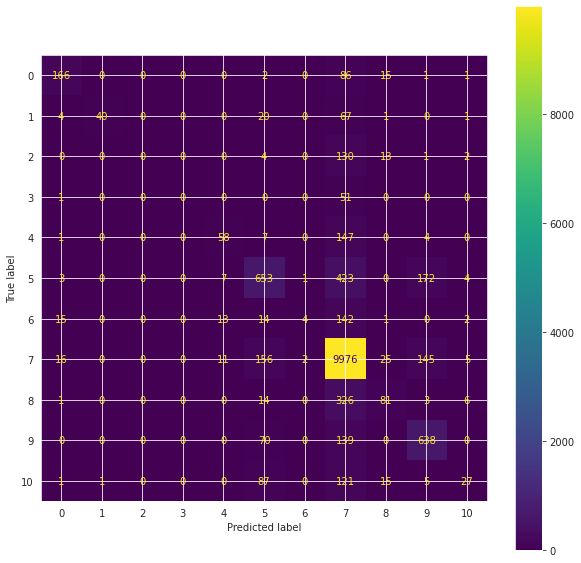

In [326]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y_val, prediction, labels= list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= list(range(num_classes)))
disp.plot(ax= ax)

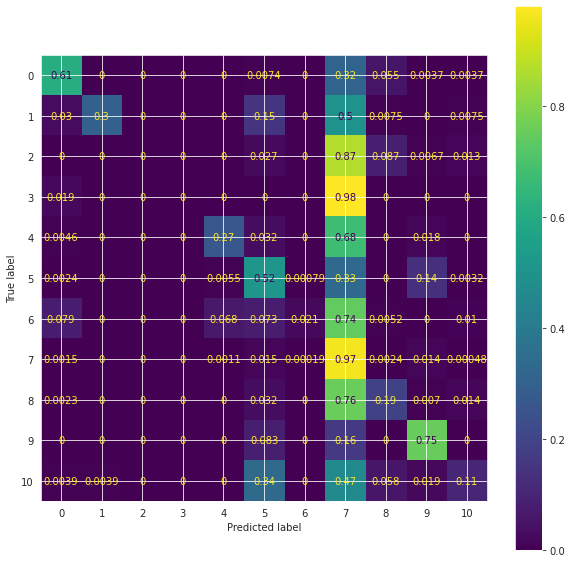

In [327]:
# confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_val, prediction, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(range(num_classes)))
disp.plot(ax=ax)